In [287]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
import seaborn as sns
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Create a more realistic dataset
data = {
    'group': np.random.choice(['A', 'B'], size=1000),
    'loan_approved': np.random.choice([0, 1], size=1000),
    'loan_amount': np.random.normal(loc=7000, scale=2000, size=1000).astype(int),
    'credit_score': np.random.normal(loc=700, scale=50, size=1000).astype(int),
    'age': np.random.normal(loc=35, scale=10, size=1000).astype(int),
    'income': np.random.normal(loc=75000, scale=15000, size=1000).astype(int)
}


In [288]:
df=pd.DataFrame(data)
df.head()


,group,loan_approved,loan_amount,credit_score,age,income
0,A,1,7355,629,43,72745
1,B,0,4329,695,28,70099
2,A,0,7760,624,22,59361
3,A,0,8221,738,24,57416
4,A,0,8119,704,30,81965


In [289]:
print(df.groupby('group').describe())

      loan_approved                                              loan_amount  \
              count      mean       std  min  25%  50%  75%  max       count   
group                                                                          
A             490.0  0.471429  0.499693  0.0  0.0  0.0  1.0  1.0       490.0   
B             510.0  0.476471  0.499936  0.0  0.0  0.0  1.0  1.0       510.0   

                    ...   age       income                              \
              mean  ...   75%   max  count          mean           std   
group               ...                                                  
A      7126.226531  ...  41.0  63.0  490.0  73903.544898  15268.398186   
B      7265.596078  ...  41.0  74.0  510.0  74183.221569  14171.784582   

                                                       
           min       25%      50%       75%       max  
group                                                  
A      27349.0  64328.25  74511.0  83897.00  122280.0  
B   

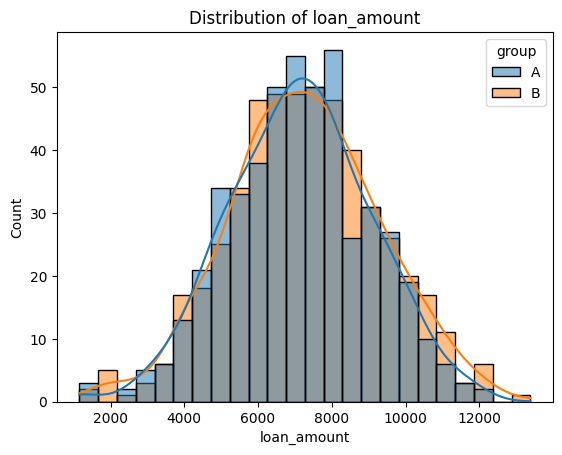

Shapiro-Wilk Test for loan_amount:
Statistic: 0.9985558390617371, p-value: 0.591462254524231
The data is normally distributed.
loan_amount - Statistics=1.687, p=0.194
Variances are equal for loan_amount.


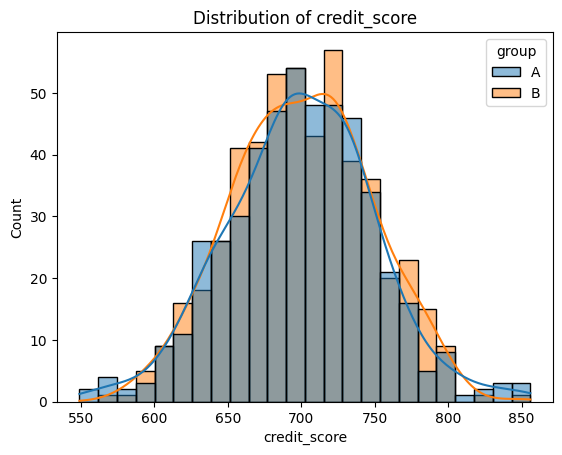

Shapiro-Wilk Test for credit_score:
Statistic: 0.9988812208175659, p-value: 0.8060687184333801
The data is normally distributed.
credit_score - Statistics=0.145, p=0.703
Variances are equal for credit_score.


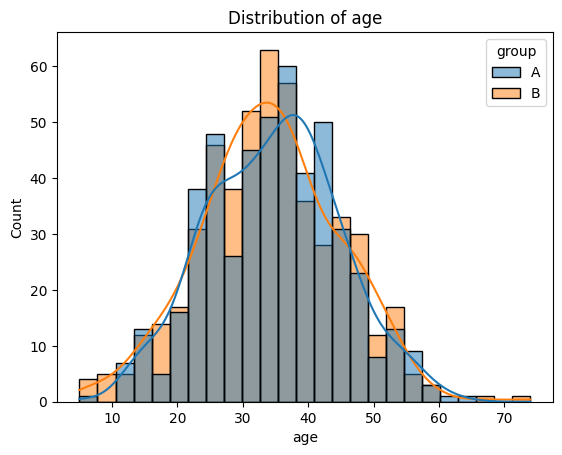

Shapiro-Wilk Test for age:
Statistic: 0.9980369210243225, p-value: 0.298439621925354
The data is normally distributed.
age - Statistics=0.290, p=0.591
Variances are equal for age.


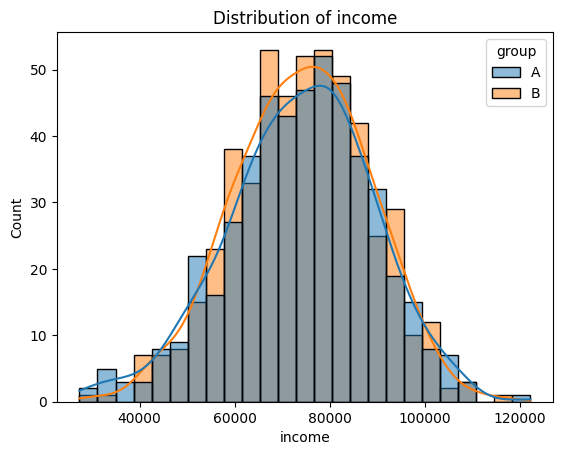

Shapiro-Wilk Test for income:
Statistic: 0.9969191551208496, p-value: 0.049983493983745575
The data is not normally distributed.
income - Statistics=1.472, p=0.225
Variances are equal for income.


In [290]:
def check_assumptions(df,continuous_vars):
  assumptions = {}

  for var in continuous_vars:
      sns.histplot(data=df, x=var, hue='group', kde=True)
      plt.title(f'Distribution of {var}')
      plt.show()
      stat,pval= stats.shapiro(df[var])
      print(f'Shapiro-Wilk Test for {var}:')
      print(f'Statistic: {stat}, p-value: {pval}')
      if pval < 0.05:
            print('The data is not normally distributed.')
            assumptions[var] = 'non_normal'
      else:
            print('The data is normally distributed.')
            assumptions[var] = 'normal'

      stat, p = stats.levene(df[df['group'] == 'A'][var], df[df['group'] == 'B'][var])
      print(f'{var} - Statistics={stat:.3f}, p={p:.3f}')
      if p > 0.05:
            print(f'Variances are equal for {var}.')
            assumptions[var] += ', homoscedastic'
      else:
            print(f'Variances are not equal for {var}.')
            assumptions[var] += ', heteroscedastic'

  return assumptions # Indent this line to be within the function

continuous_vars = ['loan_amount', 'credit_score', 'age', 'income']
assumptions = check_assumptions(df, continuous_vars)

In [291]:
for var, assumption in assumptions.items():
    print(f'{var} - {assumption}')
    if 'non_normal' in assumption:
        print(f'Transforming {var} to a normal distribution.')
        df[var]=np.log(df[var]+1)
        print(f'Applied Log transformation to {var}')
    if 'heteroscedastic' in assumption:
        print(f'Will use robust standard errors for {var}.')




loan_amount - normal, homoscedastic
credit_score - normal, homoscedastic
age - normal, homoscedastic
income - non_normal, homoscedastic
Transforming income to a normal distribution.
Applied Log transformation to income


In [292]:
# Logistic regression for loan approval
import statsmodels.formula.api as smf
df=pd.get_dummies(df,columns=['group'],drop_first=True)
logit_model = smf.logit(formula='loan_approved ~ loan_amount + credit_score + age + income + group_B', data=df).fit(cov_type='HC3')
print(logit_model.summary())







Optimization terminated successfully.
         Current function value: 0.690410
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          loan_approved   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      994
Method:                           MLE   Df Model:                            5
Date:                Wed, 24 Jul 2024   Pseudo R-squ.:                0.002002
Time:                        19:04:55   Log-Likelihood:                -690.41
converged:                       True   LL-Null:                       -691.79
Covariance Type:                  HC3   LLR p-value:                    0.7354
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.9033      3.511     -1.396      0.163     -11.785       1.979
group_B[T.True

In [293]:
# Multiple regression for loan amount
X1 = df[['credit_score', 'age', 'income', 'group_B']]
x1=sm.add_constant(X1)
y1=df['loan_amount']

lin_model=smf.ols(formula='loan_amount ~ credit_score + age + income + group_B', data=df).fit(cov_type='HC3').summary()

print(lin_model)


                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.173
Date:                Wed, 24 Jul 2024   Prob (F-statistic):              0.321
Time:                        19:04:55   Log-Likelihood:                -9005.8
No. Observations:                1000   AIC:                         1.802e+04
Df Residuals:                     995   BIC:                         1.805e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.231e+04   3363.434     

In [294]:
# If transformation was applied, use transformed variable in regression
if any('non_normal' in assumptions[var] for var in continuous_vars):
    transformed_vars = [f'{var}_log' if 'non-normal' in assumptions[var] else var for var in continuous_vars]
    X_transformed = df[transformed_vars]
    y = df['loan_amount']
    ols_model_transformed =sm.OLS(y, X_transformed).fit(cov_type='HC3')
    print(ols_model_transformed.summary())

                                 OLS Regression Results                                
Dep. Variable:            loan_amount   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.806e+32
Date:                Wed, 24 Jul 2024   Prob (F-statistic):                        0.00
Time:                        19:04:55   Log-Likelihood:                          24838.
No. Observations:                1000   AIC:                                 -4.967e+04
Df Residuals:                     996   BIC:                                 -4.965e+04
Df Model:                           4                                                  
Covariance Type:                  HC3                                                  
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

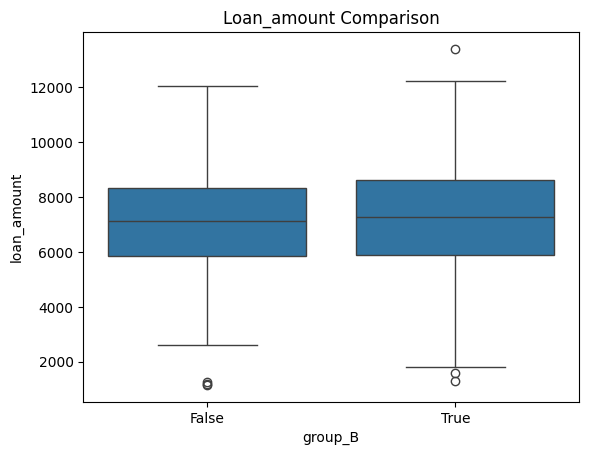

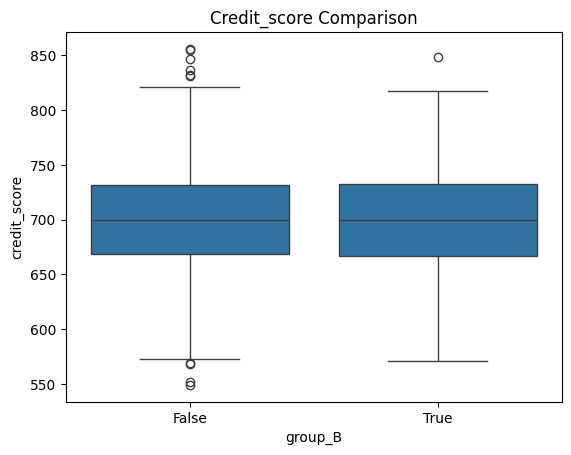

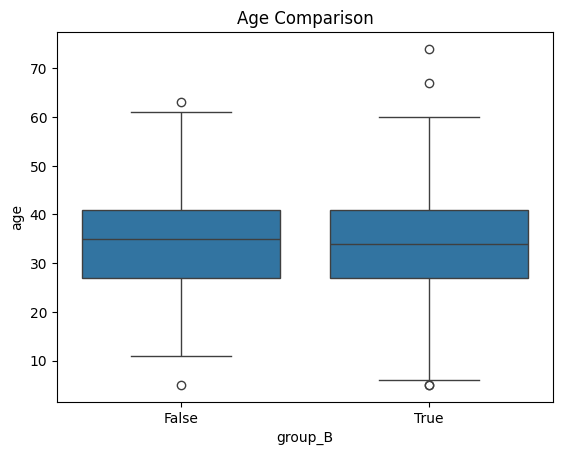

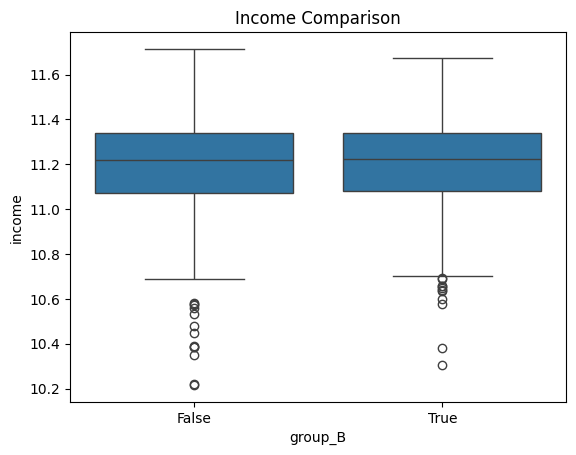

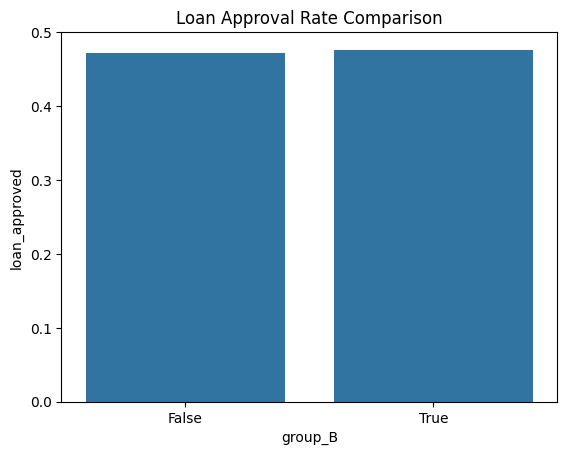

In [297]:
# Function for visualization
def visualize_results(df, continuous_vars):
    """
    Visualize the results of A/B testing.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    continuous_vars (list): List of continuous variables to visualize.
    """
    for var in continuous_vars:
        sns.boxplot(x='group_B', y=var, data=df)
        plt.title(f'{var.capitalize()} Comparison')
        plt.show()

    # Bar plot for loan approval rates
    approval_rates = df.groupby('group_B')['loan_approved'].mean().reset_index()
    sns.barplot(x='group_B', y='loan_approved', data=approval_rates)
    plt.title('Loan Approval Rate Comparison')
    plt.show()

    # Call the visualization function
visualize_results(df, continuous_vars)